# Set-up

## Installing libraries and libcudnn8

In [1]:
import os

FILEID = "1h4FWB5fw7sBDCSM-EENK1UadqKSCqg24"

contents = os.listdir(os.getcwd())

if 'MI_EEG_ClassMeth' not in contents:
    !wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id='$FILEID -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id="$FILEID -O MI_EEG_ClassMeth.zip && rm -rf /tmp/cookies.txt
    !unzip MI_EEG_ClassMeth.zip
else:
    print("MI_EEG_ClassMeth already downloaded!")

!apt-get install --allow-change-held-packages libcudnn8=8.1.1.33-1+cuda11.2 -y
!pip install -U git+https://github.com/UN-GCPDS/python-gcpds.databases
!pip install mne
!pip install pickle5
!pip install gcpds.utils
!pip install scikeras[tensorflow]
!pip install tf_keras_vis

MI_EEG_ClassMeth already downloaded!
Reading package lists... Done
Building dependency tree       
Reading state information... Done
E: Unable to locate package libcudnn8
  Cloning https://github.com/UN-GCPDS/python-gcpds.databases to /tmp/pip-req-build-nuvpzt6g
  Running command git clone --filter=blob:none --quiet https://github.com/UN-GCPDS/python-gcpds.databases /tmp/pip-req-build-nuvpzt6g
  Resolved https://github.com/UN-GCPDS/python-gcpds.databases to commit c35637e1a19d7cd21656496339c1dedae6714916
  Preparing metadata (setup.py) ... done
  Created wheel for gcpds-databases: filename=gcpds_databases-0.2-py3-none-any.whl size=94527 sha256=fdc74cf653ee018f452087c78d349fc53aacadefc4edd7f6ae3e7b2386df78b2
  Stored in directory: /tmp/pip-ephem-wheel-cache-abfsfijm/wheels/79/4b/1f/296de92be9330ad773263d339cbde2b5aff8e9514d41fb6798
Successfully built gcpds-databases
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 256.4/256.4 kB 3.8 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━

## Get Weigths and Scores

In [2]:
FILEID = "12bxViJ8j3U4RLWVbZa0SuRLcxojIdJvZ"

contents = os.listdir(os.getcwd())

if 'GFC_Motor_256_Gamma60Hz.zip' not in contents:
    !wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id='$FILEID -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id="$FILEID -O GFC_Motor_256_Gamma60Hz.zip && rm -rf /tmp/cookies.txt
    !unzip GFC_Motor_256_Gamma60Hz.zip

--2024-10-25 18:59:38--  https://docs.google.com/uc?export=download&confirm=&id=12bxViJ8j3U4RLWVbZa0SuRLcxojIdJvZ
Resolving docs.google.com (docs.google.com)... 74.125.135.113, 74.125.135.101, 74.125.135.139, ...
Connecting to docs.google.com (docs.google.com)|74.125.135.113|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=12bxViJ8j3U4RLWVbZa0SuRLcxojIdJvZ&export=download [following]
--2024-10-25 18:59:38--  https://drive.usercontent.google.com/download?id=12bxViJ8j3U4RLWVbZa0SuRLcxojIdJvZ&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 172.253.117.132, 2607:f8b0:400e:c0a::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|172.253.117.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 894052 (873K) [application/octet-stream]
Saving to: ‘GFC_Motor_256_Gamma60Hz.zip’

GFC_Motor_256_Gamma 100%[===================>]

## Import libraries

In [2]:
# freq filter 
from MI_EEG_ClassMeth.FeatExtraction import TimeFrequencyRpr

#EEG montage
from gcpds.utils.mne_handler import get_best_montage

# general
import numpy as np
from scipy.signal import resample
import pickle5 as pickle
import warnings
import mne
from time import time
warnings.filterwarnings('ignore')

# tensorlfow 
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Activation, Dropout, Conv2D, AveragePooling2D, BatchNormalization, Input, Flatten
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.layers import Layer
from tensorflow.keras.regularizers import L1L2

# scikeras
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV,StratifiedShuffleSplit
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score, cohen_kappa_score, roc_auc_score

## Define functions

In [3]:
def kappa(y_true, y_pred):
    return cohen_kappa_score(np.argmax(y_true, axis = 1),np.argmax(y_pred, axis = 1))

## PAIN dataset

In [4]:
def load_PAIN(db,sbj,f_bank,vwt,new_fs):

    channels_names = np.array(['Fp1','Fp2',
                      'F3','F4','C3','C4','P3','P4','O1','O2','F7','F8',
                      'T7','T8','P7','P8','Fz','Cz','Pz','Oz',
                      'FC1','FC2','CP1','CP2','FC5','FC6','CP5','CP6',
                      'TP9','TP10','LE','RE','P1','P2','C1','C2',
                      'FT9','FT10','AF3','AF4','FC3','FC4','CP3','CP4','PO3','PO4',
                      'F5','F6','C5','C6','P5','P6','PO9','Iz','FT7','FT8',
                      'TP7','TP8','PO7','PO8','Fpz','PO10','CPz','POz',
                      'Ne','Ma','Ext','ECG'])
    
    with open('{}BMOP_Motor_S{}.pkl'.format(db,'0' + str(sbj) if sbj < 10 else sbj), 'rb') as f:
        data = pickle.load(f)
        
    X = data['X']  # trials, channels, time
    y = data['y']
    sex = data['sex'].ravel()
    age = data['age'].ravel()
    fs = float(data['fs'])
    
    tf_repr = TimeFrequencyRpr(sfreq = fs, f_bank = f_bank, vwt = vwt)
    
    #Read electrode positions to load the best standard montage-MNE
    best_montages = get_best_montage(channels_names)
    montage = best_montages.iloc[0]['montage']
    no_channels = np.array(best_montages.iloc[0]['missings channels'])
    channels_to_remove = np.array([np.argwhere(channels_names==no)[0] for no in no_channels])[:,0]

    #Delete the missing channels the original array respecting the positions
    channels_names = np.delete(channels_names, channels_to_remove)
    X = np.delete(X, channels_to_remove, axis=1)

    #Number channels does not match with the dimension of X, 
    #thus the last channel is discarded because it has weird amplitudes
    X = X[:,:-1,:]

    info = mne.create_info(list(channels_names), sfreq=fs, ch_types="eeg")
    info.set_montage(montage)
    info

    event_id = {
        'pain/high':2,
        'resting':3,
        }

    events = [[i, 1, cls[0]] for i, cls in enumerate(y)]
    tmin = 0

    epochs = mne.EpochsArray(X, info, events=events, tmin=tmin, event_id=event_id)
    X = epochs.get_data()
    y = y-2
    X = np.squeeze(tf_repr.transform(X))
                             
    #Resampling
    if new_fs != fs:
        X = resample(X, int((X.shape[-1]/fs)*new_fs), axis = -1)
        
    return X,y,age,sex,fs,info

In [5]:
def ks_connetivity_cal(A,y):
    D=A.shape[-1]
    ks = np.zeros(D)
    pvalue = np.zeros(D)
    for d in range(D):
        ks[d],pvalue[d]=ks_2samp(A[y==0, d], A[y==1, d], alternative = 'two-side', mode = 'auto')
    return ks,pvalue

## Define the model (Gaussian functional conectivity network)

In [6]:
class GFC(Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def build(self, batch_input_shape):
        self.gammad = self.add_weight(name = 'gammad',
                                shape = (),
                                initializer = 'zeros',
                                trainable = True)
        super().build(batch_input_shape)

    def call(self, X): 
        X = tf.transpose(X, perm  = (0, 3, 1, 2)) #(N, F, C, T)
        R = tf.reduce_sum(tf.math.multiply(X, X), axis = -1, keepdims = True) #(N, F, C, 1)
        D  = R - 2*tf.matmul(X, X, transpose_b = True) + tf.transpose(R, perm = (0, 1, 3, 2)) #(N, F, C, C)

        ones = tf.ones_like(D[0,0,...]) #(C, C)
        mask_a = tf.linalg.band_part(ones, 0, -1) #Upper triangular matrix of 0s and 1s (C, C)
        mask_b = tf.linalg.band_part(ones, 0, 0)  #Diagonal matrix of 0s and 1s (C, C)
        mask = tf.cast(mask_a - mask_b, dtype=tf.bool) #Make a bool mask (C, C)
        triu = tf.expand_dims(tf.boolean_mask(D, mask, axis = 2), axis = -1) #(N, F, C*(C-1)/2, 1)
        sigma = tfp.stats.percentile(tf.math.sqrt(triu), 50, axis = 2, keepdims = True) #(N, F, 1, 1)

        A = tf.math.exp(-1/(2*tf.pow(10., self.gammad)*tf.math.square(sigma))*D) #(N, F, C, C)
        A.set_shape(D.shape)
        return A

    def compute_output_shape(self, batch_input_shape):
        N, C, T, F = batch_input_shape.as_list()
        return tf.TensorShape([N, F, C, C])

    def get_config(self):
        base_config = super().get_config()
        return {**base_config}


class get_triu(Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def build(self, batch_input_shape):
        super().build(batch_input_shape)

    def call(self, X): 
        N, F, C, C = X.shape
        ones = tf.ones_like(X[0,0,...]) #(C, C)
        mask_a = tf.linalg.band_part(ones, 0, -1) #Upper triangular matrix of 0s and 1s (C, C)
        mask_b = tf.linalg.band_part(ones, 0, 0)  #Diagonal matrix of 0s and 1s (C, C)
        mask = tf.cast(mask_a - mask_b, dtype=tf.bool) #Make a bool mask (C, C)
        triu = tf.expand_dims(tf.boolean_mask(X, mask, axis = 2), axis = -1) #(N, F, C*(C-1)/2, 1)

        triu.set_shape([N,F,int(C*(C-1)/2),1])
        return triu

    def compute_output_shape(self, batch_input_shape):
        N, F, C, C = batch_input_shape.as_list()
        return tf.TensorShape([N, F, int(C*(C-1)/2),1])

    def get_config(self):
        base_config = super().get_config()
        return {**base_config}
    
    
def GFC_triu_net_avg(nb_classes: int,
          Chans: int,
          Samples: int,
          l1: int = 0, 
          l2: int = 0, 
          dropoutRate: float = 0.5,
          filters: int = 1, 
          maxnorm: float = 2.0,
          maxnorm_last_layer: float = 0.5,
          kernel_time_1: int = 20,
          strid_filter_time_1: int = 1,
          bias_spatial: bool = False) -> Model:


    input_main   = Input((Chans, Samples, 1),name='Input')                    
    
    block        = Conv2D(filters,(1,kernel_time_1),strides=(1,strid_filter_time_1),
                            use_bias=bias_spatial, name='Conv2D_1',
                            kernel_constraint = max_norm(maxnorm, axis=(0,1,2))
                            )(input_main)
    
    block        = BatchNormalization(epsilon=1e-05, momentum=0.1)(block)

    block        = Activation('elu')(block)      
    
    block        = GFC(name="gfc")(block)

    block        = get_triu()(block)

    block        = AveragePooling2D(pool_size=(block.shape[1],1),strides=(1,1))(block)
    
    block        = BatchNormalization(epsilon=1e-05, momentum=0.1)(block)

    block        = Activation('elu')(block) 
    
    block        = Flatten(name='fc')(block)    

    block        = Dropout(dropoutRate)(block) 

    block        = Dense(nb_classes, kernel_regularizer=L1L2(l1=l1,l2=l2),name='logits',
                              kernel_constraint = max_norm(maxnorm_last_layer)
                              )(block)

    softmax      = Activation('softmax',name='output')(block)
    
    return Model(inputs=input_main, outputs=softmax)

# Experiment

## Experiment configuration 

In [7]:
import os 

seed = 23
folds = 5
epochs_train = 500

n_subjects = 51

PATH = f'{os.getcwd()}'

## Run experiment

In [8]:
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import ks_2samp
from scipy.spatial.distance import squareform

tf.random.set_seed(seed)

num_class = 2     

subjects = np.arange(n_subjects) + 1

db = '../input/brain-mediators-of-pain-motor/'

load_args = dict(db = db,
            f_bank = np.asarray([[4., 60.]]),
            vwt = np.asarray([[0.5,2.5]]),
            new_fs = 256.0)

print("Starting experiment...\n")

load_args['sbj'] = 1 
    
X_train, y_train, age, sex, fs, _ = load_PAIN(**load_args)

trials = []

subjects = np.delete(subjects, [17])

gfcnet_scores = np.zeros((n_subjects,8))

Nfilters_ = np.zeros((n_subjects))
kernel_time_ = np.zeros((n_subjects))

Nfilters__ = np.zeros((n_subjects))
kernel_time__ = np.zeros((n_subjects))

full_path = PATH

GFC_PATH = os.path.join(os.getcwd(), "GFC_Motor_256_Gamma60Hz")

C = X_train.shape[1]
ks = np.zeros((subjects.shape[0], int(C*(C-1)/2)))
pvalue = np.zeros((subjects.shape[0], int(C*(C-1)/2)))

ks_ = np.zeros((subjects.shape[0], int(C*(C-1)/2)))
pvalue_ = np.zeros((subjects.shape[0], int(C*(C-1)/2)))

age_ = np.zeros(gfcnet_scores.shape[0])
sex_ = np.zeros(gfcnet_scores.shape[0])
rage_ = np.zeros(gfcnet_scores.shape[0])

for idx, sbj in enumerate(subjects):
    print(f"\nLoading subject: {sbj} \n")
    load_args['sbj'] = sbj 
    
    X_train, y_train, age, sex, fs, _ = load_PAIN(**load_args)
    
    scores_path = GFC_PATH + f'/Subject{sbj}.p'
    weights_path = GFC_PATH + f'/Subject{sbj}_weights.h5'
    
    with open(scores_path, 'rb') as f:
        cv = pickle.load(f)
    
    gfcnet_scores[idx] = cv['mean_test_Accuracy'][cv['best_index_']],cv['std_test_Accuracy'][cv['best_index_']],cv['mean_test_Kappa'][cv['best_index_']],cv['std_test_Kappa'][cv['best_index_']],cv['mean_test_AUC'][cv['best_index_']],cv['std_test_AUC'][cv['best_index_']], 0, 0
    
    Nfilters__[idx] = cv['params'][cv['best_index_']]['filters']
    kernel_time__[idx] = cv['params'][cv['best_index_']]['kernel_time_1']
    
    model = GFC_triu_net_avg(nb_classes = num_class,
            Chans = X_train.shape[1],
            Samples = X_train.shape[2],
            filters = int(Nfilters__[idx]), 
            kernel_time_1 =int(kernel_time__[idx]))

    model.load_weights(weights_path)
    
    layer_name='fc'
    
    FC_layer = Model(inputs=model.input,
                                  outputs=model.get_layer(layer_name).output)
    
    fc_layer_pred = FC_layer.predict(X_train)

    ks_[idx],pvalue_[idx] = ks_connetivity_cal(fc_layer_pred,y_train.reshape(-1))
    
    ent = pvalue_[idx].mean()
    ksEnt = ks_[idx].mean()
    
    gfcnet_scores[idx, -2] = ent

    gfcnet_scores[idx, -1] = ksEnt

    age_[i] = age[0]
    
    if sex[0] == 'f':
        sex_[i] = 0
    else: 
        sex_[i] = 1
        
    if age[0] <= 25:
        rage_[i] = 0
    elif age[0] > 25 and age[0] <= 30:
        rage_[i] = 1
    elif age[0] >= 30:
        rage_[i] = 2

Starting experiment...

Not setting metadata
40 matching events found
No baseline correction applied
0 projection items activated

Loading subject: 1 

Not setting metadata
40 matching events found
No baseline correction applied
0 projection items activated
2/2 [==============================] - 1s 21ms/step

Loading subject: 2 

Not setting metadata
40 matching events found
No baseline correction applied
0 projection items activated
2/2 [==============================] - 0s 25ms/step

Loading subject: 3 

Not setting metadata
40 matching events found
No baseline correction applied
0 projection items activated
2/2 [==============================] - 0s 20ms/step

Loading subject: 4 

Not setting metadata
40 matching events found
No baseline correction applied
0 projection items activated
2/2 [==============================] - 0s 21ms/step

Loading subject: 5 

Not setting metadata
40 matching events found
No baseline correction applied
0 projection items activated
2/2 [=================

### UMAP

0.14648440655233227


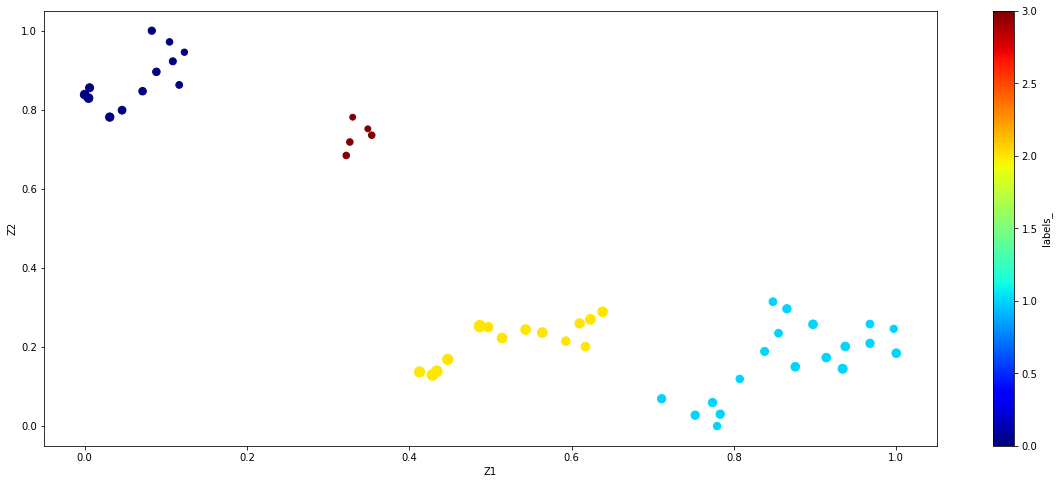

In [13]:
from umap import UMAP
from sklearn.preprocessing import MinMaxScaler
from scipy.spatial.distance import cdist, squareform
from sklearn.cluster import KMeans
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

min_samples = 4
scaZ = MinMaxScaler()
scaZ1 = MinMaxScaler()

reducer = UMAP(n_components=2, random_state=42, n_neighbors=min_samples, min_dist=0.1)
Z_ = scaZ.fit_transform(reducer.fit_transform(scaZ1.fit_transform(gfcnet_scores)))

D_ = cdist(gfcnet_scores,gfcnet_scores)
eps_ = np.percentile(squareform(D_), 5)
print(eps_)

n_groups = 4
clus = KMeans(n_clusters=n_groups, random_state=42)
clus.fit(Z_)
gfcnet_labels = clus.labels_

columns = ['ACC', 'stdACC', 'Kappa', 'stdKappa', 'AUC', 'stdAUC', 'H2pvalue', 'H2KS', 'Z1', 'Z2', 'labels_', 'sex', 'age', 'rage']
data_ = pd.DataFrame(data=np.c_[gfcnet_scores, Z_, gfcnet_labels, sex_, age_, rage_], columns=columns)

embedding = pd.DataFrame(Z_, columns=['UMAP1', 'UMAP2'])
embedding['Sex'] = sex_

fig, ax = plt.subplots(1, 1, figsize=(20, 8))


data_.plot(kind='scatter', x='Z1', y='Z2', ax=ax, c='labels_', s=-50*np.log(1-data_['ACC']), cmap='jet', legend=False)
plt.show()

In [14]:
from matplotlib.colors import LinearSegmentedColormap

colors = [(0, 0, 0),
          (1, 0, 0),     # Red (0.5)
          (1, 0.5, 0),   # Orange (0.6)
          (1, 1, 0),     # Yellow (0.75)
          (0.6, 1, 0.6)] # Light Green (1.0)

values = [0, 0.5, 0.6, 0.75, 1.0]

custom_cmap = LinearSegmentedColormap.from_list('custom_red_orange_green', list(zip(values, colors)))

In [24]:
plt.rcParams.update({'font.size': 28})

gInds = {3: 'GI', 2: 'GII', 1: 'GIII', 4: 'GIV'}

gfcnet_labels_ = [gInds[lab + 1] for lab in gfcnet_labels]

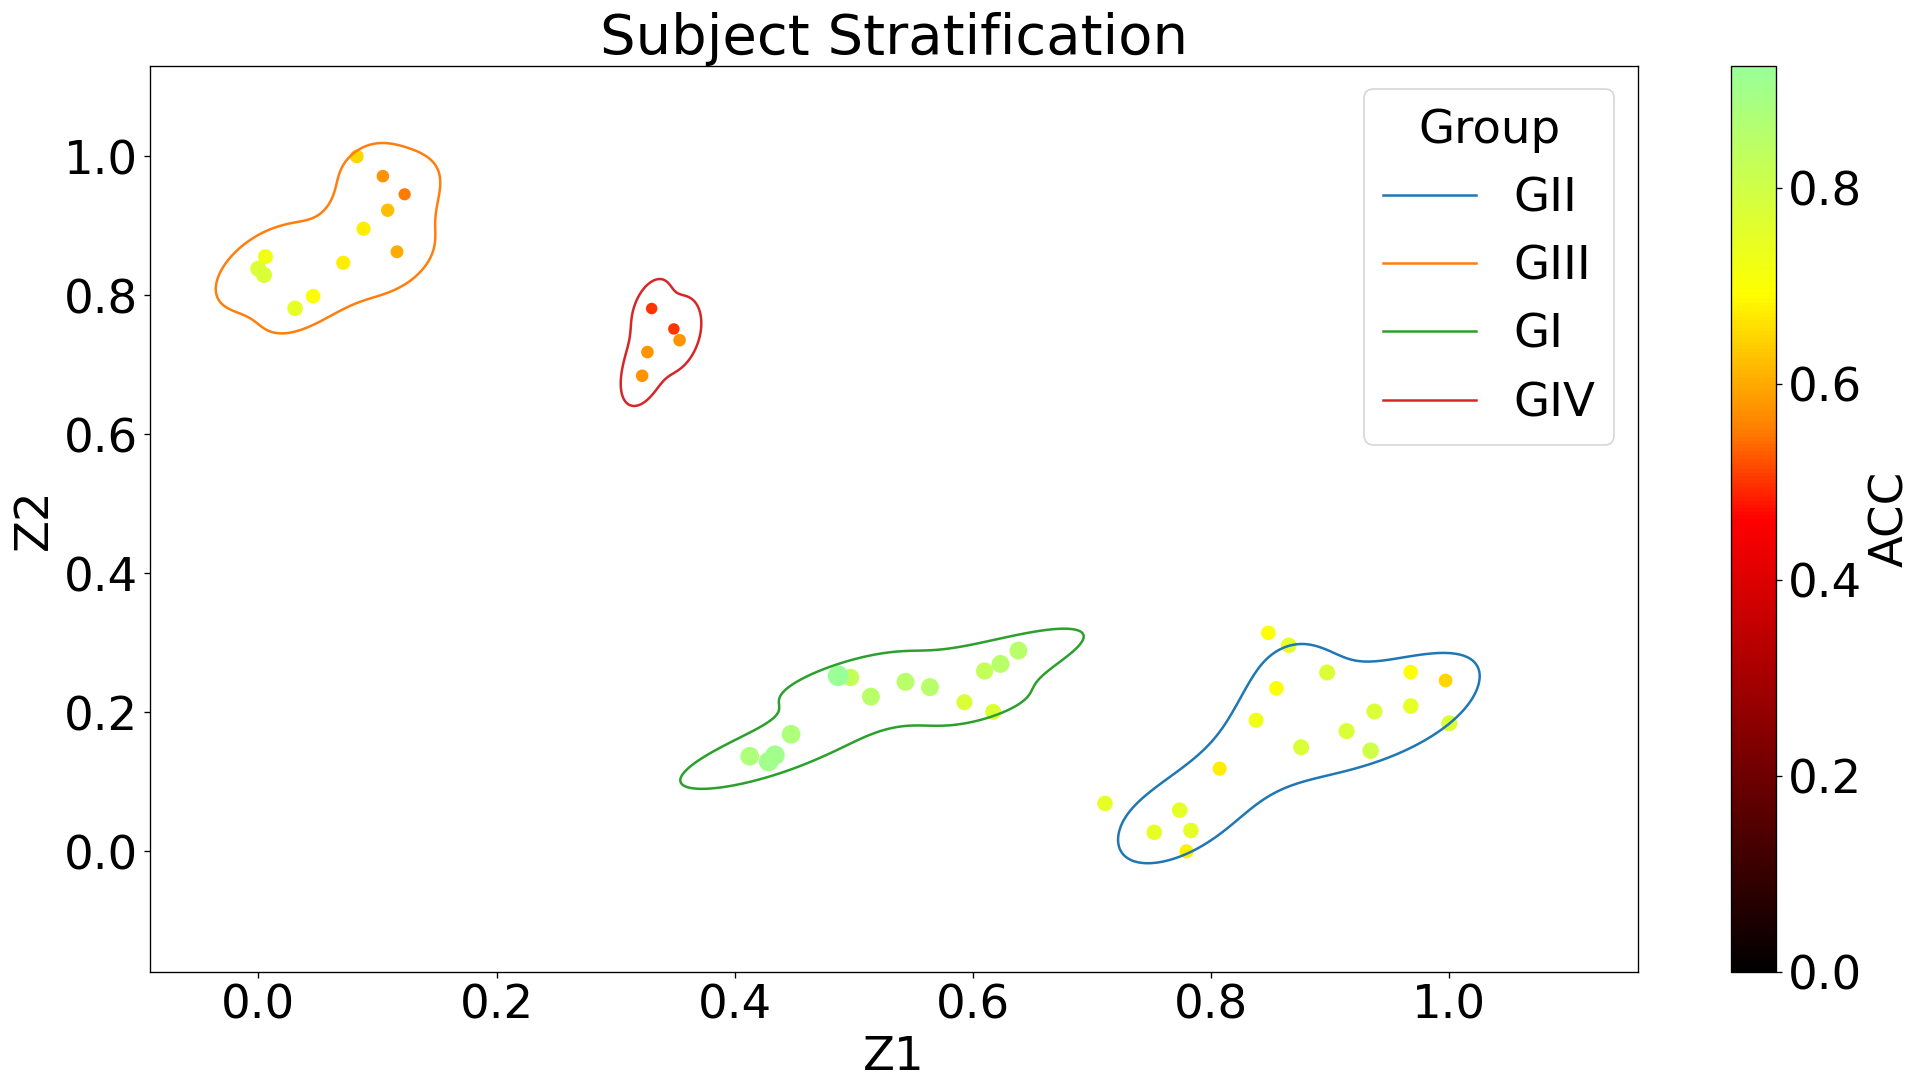

In [26]:
embedding = pd.DataFrame(Z_, columns=['UMAP1', 'UMAP2'])
embedding['Group'] = gfcnet_labels_
# embedding['Group'] = gfcnet_labels

fig, ax = plt.subplots(1, 1, figsize=(20, 10), dpi=120)
data_.plot(kind='scatter', x='Z1', y='Z2', ax=ax, c='ACC', s=-50*np.log(1-data_['ACC']), cmap=custom_cmap, legend=False)
sns.kdeplot(x='UMAP1', y='UMAP2', data=embedding, hue='Group', levels=2, thresh=.2)
plt.title('Subject Stratification')
plt.savefig('SubjectStratificationAcc' + ".png")
plt.show()